Import libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
import re
import string
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import normalize
from sklearn.cluster import KMeans, Birch
from subprocess import check_output
from wordcloud import WordCloud, STOPWORDS

import os
'''print(os.listdir("../input"))'''

['all.csv']


In [2]:
data = pd.read_csv('all.csv')
data.head()

,author,content,poem name,age,type
0,WILLIAM SHAKESPEARE,Let the bird of loudest lay\r\nOn the sole Ara...,The Phoenix and the Turtle,Renaissance,Mythology & Folklore
1,DUCHESS OF NEWCASTLE MARGARET CAVENDISH,"Sir Charles into my chamber coming in,\r\nWhen...",An Epilogue to the Above,Renaissance,Mythology & Folklore
2,THOMAS BASTARD,"Our vice runs beyond all that old men saw,\r\n...","Book 7, Epigram 42",Renaissance,Mythology & Folklore
3,EDMUND SPENSER,"Lo I the man, whose Muse whilome did maske,\r\...","from The Faerie Queene: Book I, Canto I",Renaissance,Mythology & Folklore
4,RICHARD BARNFIELD,"Long have I longd to see my love againe,\r\nSt...",Sonnet 16,Renaissance,Mythology & Folklore


In [3]:
data.shape

(573, 5)

In [4]:
data.columns

Index(['author', 'content', 'poem name', 'age', 'type'], dtype='object')

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 573 entries, 0 to 572
Data columns (total 5 columns):
author       573 non-null object
content      573 non-null object
poem name    571 non-null object
age          573 non-null object
type         573 non-null object
dtypes: object(5)
memory usage: 22.5+ KB


Column 'content' contains the poems

In [6]:
data['content'].head()

0    Let the bird of loudest lay\r\nOn the sole Ara...
1    Sir Charles into my chamber coming in,\r\nWhen...
2    Our vice runs beyond all that old men saw,\r\n...
3    Lo I the man, whose Muse whilome did maske,\r\...
4    Long have I longd to see my love againe,\r\nSt...
Name: content, dtype: object

## Preprocessing

Let's see which words have appeared most of the times

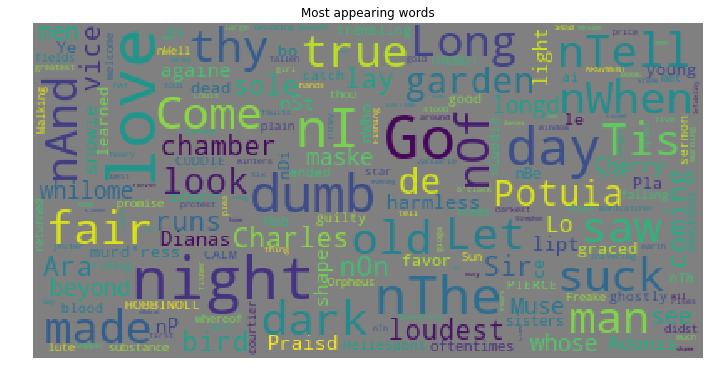

In [7]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(
                          background_color='grey',
                          stopwords=stopwords,
                          max_words=200,
                          max_font_size=40, 
                          random_state=15
                         ).generate(str(data['content']))

fig = plt.figure(1,figsize=(12,18))
plt.imshow(wordcloud)
plt.title('Most appearing words')
plt.axis('off')
plt.show()

Let's convert the characters to lower case so that the model can interpret 'HAPPY' and 'happy' as the same words 

In [8]:
data['content'] = data['content'].apply(lambda x: x.lower())

We also remove the different punctuations

In [9]:
data['content'] = data['content'].str.replace("[^a-zA-Z#']", " ")

In [10]:
data.head()

,author,content,poem name,age,type
0,WILLIAM SHAKESPEARE,let the bird of loudest lay on the sole arabi...,The Phoenix and the Turtle,Renaissance,Mythology & Folklore
1,DUCHESS OF NEWCASTLE MARGARET CAVENDISH,sir charles into my chamber coming in when i...,An Epilogue to the Above,Renaissance,Mythology & Folklore
2,THOMAS BASTARD,our vice runs beyond all that old men saw an...,"Book 7, Epigram 42",Renaissance,Mythology & Folklore
3,EDMUND SPENSER,lo i the man whose muse whilome did maske a...,"from The Faerie Queene: Book I, Canto I",Renaissance,Mythology & Folklore
4,RICHARD BARNFIELD,long have i longd to see my love againe stil...,Sonnet 16,Renaissance,Mythology & Folklore


Tokenization -  This process will split the strings into individual words called tokens

In [11]:
tokenized_content = data['content'].apply(lambda x: x.split())
tokenized_content.head()
from nltk.stem.porter import *
stemmer = PorterStemmer()

tokenized_content = tokenized_content.apply(lambda x: [stemmer.stem(i) for i in x]) # stemming
tokenized_content.head()

0    [let, the, bird, of, loudest, lay, on, the, so...
1    [sir, charl, into, my, chamber, come, in, when...
2    [our, vice, run, beyond, all, that, old, men, ...
3    [lo, i, the, man, whose, muse, whilom, did, ma...
4    [long, have, i, longd, to, see, my, love, agai...
Name: content, dtype: object

In [12]:
for i in range(len(tokenized_content)):
    tokenized_content[i] = ' '.join(tokenized_content[i])
data['content'] = tokenized_content

Now we remove the stopwords which are considered as important (this,that,a, an, etc).

In [13]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
import string
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all stopwords
    2. Returns a list of the cleaned text
    # Now just remove any stopwords
    """
    return [word for word in mess.split() if word.lower() not in stopwords.words('english')]

In [14]:
vectorizer = CountVectorizer(analyzer=text_process)

Now we convert the dense data into a sparse data.

In [15]:
sparsed_data = vectorizer.fit_transform(data['content'])
sparsed_data

<573x8534 sparse matrix of type '<class 'numpy.int64'>'
	with 42990 stored elements in Compressed Sparse Row format>

In [16]:
print ('Shape of Sparse Matrix: ', sparsed_data.shape)
print ('Amount of Non-Zero occurences: ', sparsed_data.nnz)
print ('sparsity: %.2f%%' % (100.0 * sparsed_data.nnz /
                             (sparsed_data.shape[0] * sparsed_data.shape[1])))

Shape of Sparse Matrix:  (573, 8534)
Amount of Non-Zero occurences:  42990
sparsity: 0.88%


Now we use TF-IDF method to convert the data into features.

TF-IDF works by penalizing the common words by assigning them lower weights while giving importance to words which are rare in the entire corpus but appear in good numbers in few documents.

In [17]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer().fit(sparsed_data)
train = tfidf_transformer.transform(sparsed_data)

## Training and Classifying

As asked in the question to try to classify the poems into 4 genre. So, I have applied two clustering algorithms to classify into 4 clusters.

Using K-Means Clustering

In [18]:
inertia = []
for n in range(1 , 11):
    algorithm = (KMeans(n_clusters = n ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  ) )
    algorithm.fit(train)
    inertia.append(algorithm.inertia_)

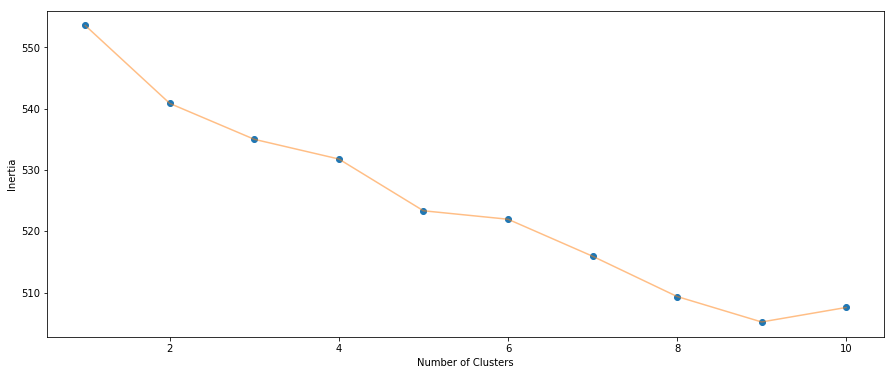

In [19]:
plt.figure(1 , figsize = (15 ,6))
plt.plot(np.arange(1 , 11) , inertia , 'o')
plt.plot(np.arange(1 , 11) , inertia , '-' , alpha = 0.5)
plt.xlabel('Number of Clusters') , plt.ylabel('Inertia')
plt.show()


Selecting N Clusters based in Inertia (Squared Distance between Centroids and data points, should be less)¶
After plotting the above plot it is found out that 5 could be an ideal number of clusters. I have used 4 clusters

Now training is done

In [20]:
algorithm = (KMeans(n_clusters = 4 ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111))
algorithm.fit(train)
labels1 = algorithm.labels_
centroids1 = algorithm.cluster_centers_

In [21]:
data['cluster_num'] = labels1

Let's see what could be the genre :-

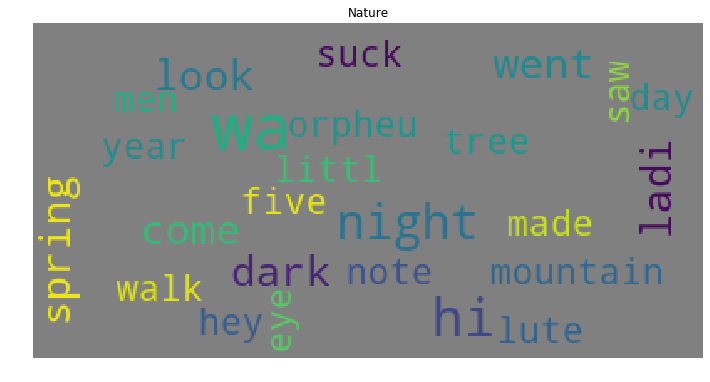

In [22]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(
                          background_color='grey',
                          stopwords=stopwords,
                          max_words=25,
                          max_font_size=40, 
                          random_state=30
                         ).generate(str(data[data['cluster_num']==0]['content']))

fig = plt.figure(1,figsize=(12,18))
plt.title('Nature')
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

For the cluster number 0 as classified by k-means we see that in the top 25 words there are words like Spring, mountaion, tree, night, eye, ladi etc. So, we can classify this cluster as 'Nature or Beauty' gnere.

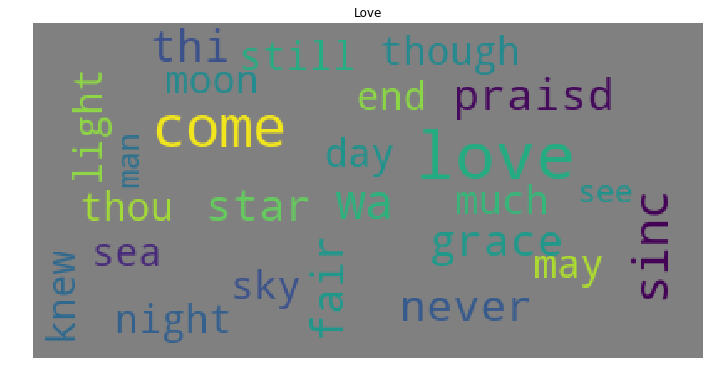

In [23]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(
                          background_color='grey',
                          stopwords=stopwords,
                          max_words=25,
                          max_font_size=40, 
                          random_state=30
                         ).generate(str(data[data['cluster_num']==1]['content']))

fig = plt.figure(1,figsize=(12,18))
plt.title('Love')
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

For the cluster number 1 as classified by k-means we see that in the top 25 words there are words like love, fair, grace, moon, sea etc. So, we can classify this cluster as 'Love' gnere.

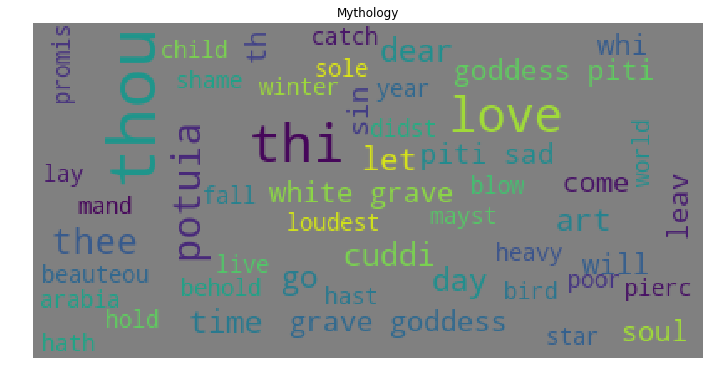

In [24]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(
                          background_color='grey',
                          stopwords=stopwords,
                          max_words=50,
                          max_font_size=40, 
                          random_state=15
                         ).generate(str(data[data['cluster_num']==2]['content']))

fig = plt.figure(1,figsize=(12,18))
plt.title('Mythology')
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

For the cluster number 2 as classified by k-means we see that in the top 50 words. Love has also appeared many times. But other important words which did not appeared in other clusters can be given more weightage. So, we see that goddess, grave, soul, sin, etc. So, we can classify this group as 'mythology' gnere.

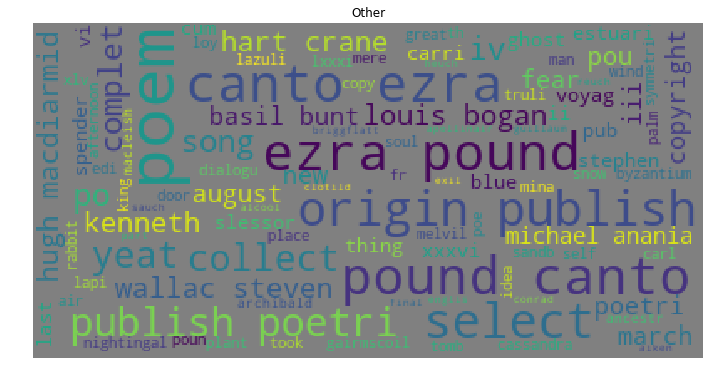

In [25]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(
                          background_color='grey',
                          stopwords=stopwords,
                          max_words=100,
                          max_font_size=40, 
                          random_state=15
                         ).generate(str(data[data['cluster_num']==3]['content']))

fig = plt.figure(1,figsize=(12,18))
plt.title('Other')
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Let's categorize the last cluster as 'other' group.

Now let's use 2nd algorithm - Birch clustering algorithm

In [26]:
brc = Birch(branching_factor=100, n_clusters=4, threshold=0.5,compute_labels=True)

In [27]:
brc.fit(train)
labels2 = brc.labels_

In [28]:
data['cluster_num2'] = labels2

Let's categorize the clusters into gnere :-

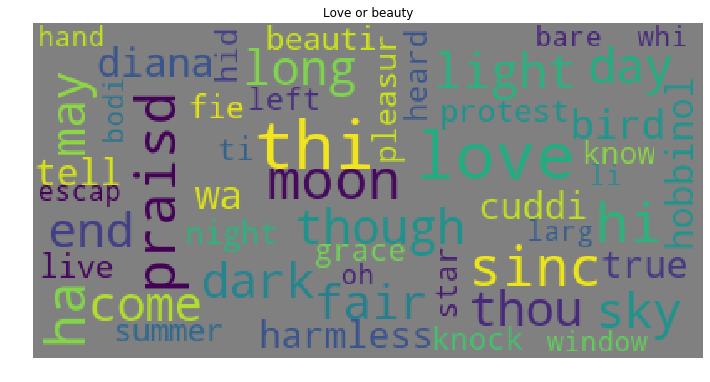

In [29]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(
                          background_color='grey',
                          stopwords=stopwords,
                          max_words=50,
                          max_font_size=40, 
                          random_state=30
                         ).generate(str(data[data['cluster_num2']==0]['content']))

fig = plt.figure(1,figsize=(12,18))
plt.title('Love or beauty')
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

We can classify this as and love or beauty gnere

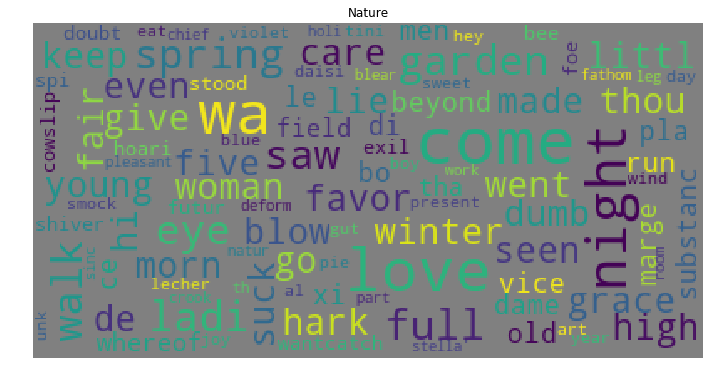

In [30]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(
                          background_color='grey',
                          stopwords=stopwords,
                          max_words=100,
                          max_font_size=40, 
                          random_state=30
                         ).generate(str(data[data['cluster_num2']==1]['content']))

fig = plt.figure(1,figsize=(12,18))
plt.title('Nature')
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Some words like spring, garden appeared. So, we can catogorize it as nature.

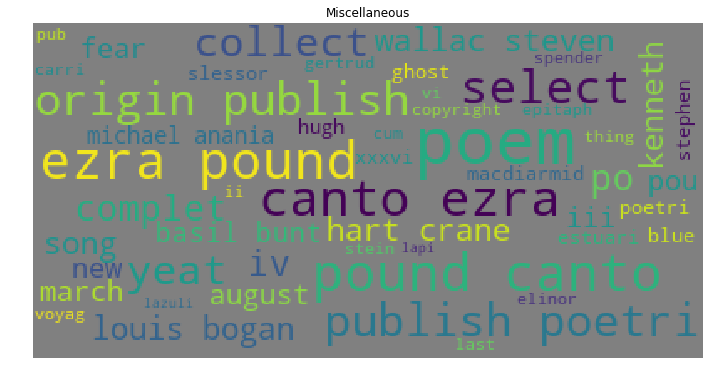

In [31]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(
                          background_color='grey',
                          stopwords=stopwords,
                          max_words=50,
                          max_font_size=40, 
                          random_state=30
                         ).generate(str(data[data['cluster_num2']==2]['content']))

fig = plt.figure(1,figsize=(12,18))
plt.title('Miscellaneous')
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

We can categorize this as Miscellaneous

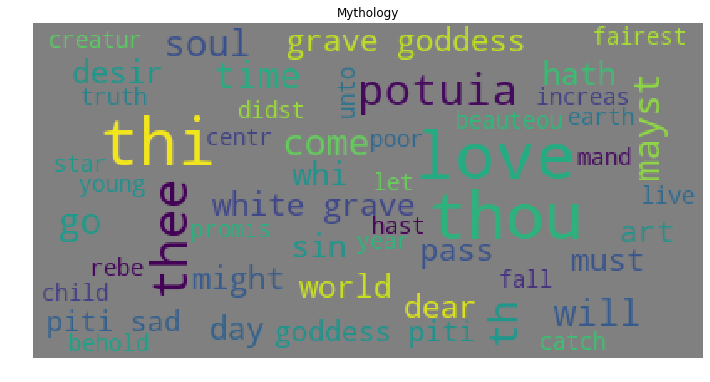

In [32]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(
                          background_color='grey',
                          stopwords=stopwords,
                          max_words=50,
                          max_font_size=40,
                          random_state=30
                         ).generate(str(data[data['cluster_num2']==3]['content']))

fig = plt.figure(1,figsize=(12,18))
plt.title('Mythology')
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

Some terms like goddess, grave,soul, truth, etc are there. So we can catogorize it as Mythology gnere.

In [33]:
#######

##### We have tried to classify using both the algorithms. Both the algorithms gave a little different results than one another. But overall, we were able to differentiate between different clusters and named thosed clusters visualizing the wordclouds.

#### We can make a new dataset with poems, poets and the classified clusters

In [34]:
data1 = data[['author','content','poem name','cluster_num','cluster_num2']]

In [35]:
data1['cluster_num'].replace(0,'Nature',inplace = True)
data1['cluster_num'].replace(1,'Love',inplace = True)
data1['cluster_num'].replace(2,'mythology',inplace = True)
data1['cluster_num'].replace(3,'Others',inplace = True)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [36]:
data1['cluster_num2'].replace(0,'Love or beauty',inplace = True)
data1['cluster_num2'].replace(1,'Nature',inplace = True)
data1['cluster_num2'].replace(2,'Miscellaneous',inplace = True)
data1['cluster_num2'].replace(3,'Mythology',inplace = True)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [37]:
data1.head()

,author,content,poem name,cluster_num,cluster_num2
0,WILLIAM SHAKESPEARE,let the bird of loudest lay on the sole arabia...,The Phoenix and the Turtle,mythology,Love or beauty
1,DUCHESS OF NEWCASTLE MARGARET CAVENDISH,sir charl into my chamber come in when i wa wr...,An Epilogue to the Above,Love,Love or beauty
2,THOMAS BASTARD,our vice run beyond all that old men saw and f...,"Book 7, Epigram 42",Nature,Nature
3,EDMUND SPENSER,lo i the man whose muse whilom did mask as tim...,"from The Faerie Queene: Book I, Canto I",Love,Love or beauty
4,RICHARD BARNFIELD,long have i longd to see my love again still h...,Sonnet 16,Love,Love or beauty


Let's see the count of each category

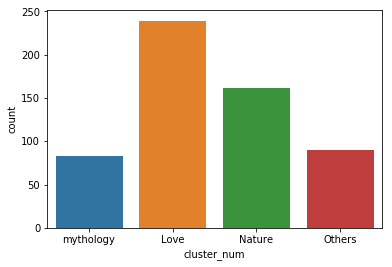

In [38]:
### results by k-means
sns.countplot('cluster_num',data = data1)

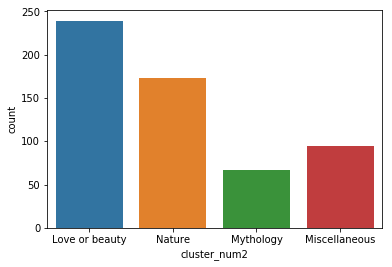

In [39]:
### results by birch clustering
sns.countplot('cluster_num2',data = data1)